In [0]:
import urllib.request
import cv2
import numpy as np         
import pandas as pd        
import matplotlib.pyplot as plt

In [0]:
def read_image_from_drive(url, type):
  resp = urllib.request.urlopen(url)
  img_byte = np.asarray(bytearray(resp.read()), dtype="uint8")
  if type == 0:
    return cv2.imdecode(img_byte, cv2.IMREAD_GRAYSCALE)
  else:
    img = cv2.imdecode(img_byte, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

In [0]:
def plot_images_inline(imgs):
  fig = plt.figure()
  for n, img in enumerate(imgs):
      fig.add_subplot(1, np.ceil(len(imgs)/float(1)), n + 1)
      plt.imshow(img, cmap='gray')

  fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
  plt.show()

# Aplicações OpenCV

## Recuperando informação de profundidade em imagens 2D

Existem [trabalhos na literature](http://www.cs.cornell.edu/~asaxena/reconstruction3d/) que tentam recuperar a informação 3D (profundidade) de uma cena utilizando somente a informação 2D de uma única imagem, porém sem muita eficácia. Com informações adicionais, já possível recuperar esta informação com maior eficiência, por exemplo:
  - Se você sabe que existe um rosto na imagem, assim você sabe como é o formato de uma face em 3D, assim é possível extrair informação de profundidade analisando sombras e ângulo da face

Utilizando um conceito de disparidade e duas imagens geradas apartir de uma configuração chamada _stereo_ podemos inferir a profundidade de uma cena.  




#### Disparidade e imagens estéreo




Configuração estéreo é uma configuração de ângulos feitos com duas camêras para capturar uma cena em ângulos direntes (esquerdo e direito).

Se obtivermos a correspondência entre os pontos das duas imagens podemos calcular a distância do ponto correspondente no mundo real. A diferença da posição entre as imagens da direita e esquerda é chamado de **disparidade**. Pontos no mundo real que são muito longes geram uma disparidade pequena, e pontos que são muito pertos geram uma disparidade alta. A **profundidade** é inversamente proporcional a disparidade.

<img width="400" alt="portfolio_view" src="https://docs.google.com/uc?export=download&id=1ZHN8kETVyXVNnmJVHWZ91EUtBp5YvdHd" style="">

<img width="300" alt="portfolio_view" src="https://docs.google.com/uc?export=download&id=1uCY-pxTnqPy4vAK_kG_kYxb3P5LGnlMu" style="">
<img width="300" alt="portfolio_view" src="https://docs.google.com/uc?export=download&id=14dzWx0n_zNGELLTwJp7qWsDXtp-eRygo" style="">




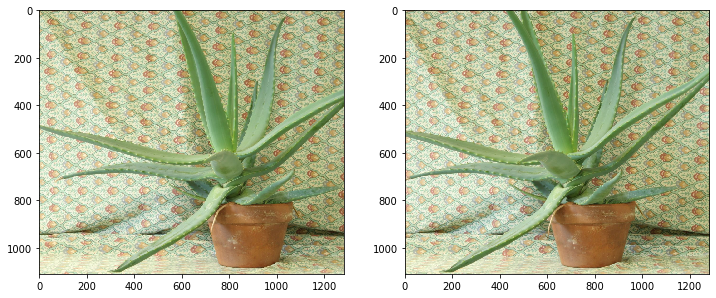

In [4]:
imgL = read_image_from_drive('https://docs.google.com/uc?export=download&id=1o3Ah4Rsiec2wUyNNt5WZQNaXRAQhFUZq', 1)
imgR = read_image_from_drive('https://docs.google.com/uc?export=download&id=1FSC8rW4cR62XKrAuZ-SahBUCIFhdcgQf', 1)
plot_images_inline([imgL, imgR])

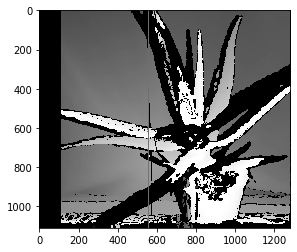

In [5]:
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 16,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32
)
disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

plt.imshow(disp,cmap='gray')

## Calculando tamanho de objetos em uma imagem 2D

### A proporção de "pixels por métrica" (_pixels per metric_)

Uma imagem pode estar em diferentes escalas, como os objetos que se encontram dispostos nela. Assim, para encontrar o tamanho de um objeto em uma imagem, primeiro precisamos de um objeto de referência com as seguintes propriedades:
  - Precisamos saber as dimensões deste objeto
  - Deve ser um objeto de fácil rastreamento na imagem, como localização na imagem ou uma cor específica

Assim, conseguimos encontrar o objeto e mapear uma **proporção de um pixel em relação uma medida de distância**

A seguir vamos encontrar as medidas de distância nos objetos da seguinte imagem, com base no objeto mais a esquerda, ou seja, na moeda da esquerda.

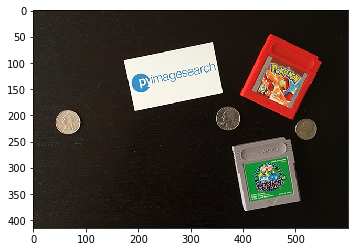

In [6]:
image = read_image_from_drive('https://docs.google.com/uc?export=download&id=1wNp_geQgGndwOKlkK13yrIDd1Xft-OI1', 1)
plt.imshow(image)

A seguir importamos algumas bibliotecas e criamos uma função auxiliar que calcula o ponto central dado dois conjuntos de coordenadas

In [0]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils
 
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

Em seguida, aplicamos o processo visto nas aulas para detectar as bordas das imagem e encontrar seus contornos. Perceba que os contornos são ordenados

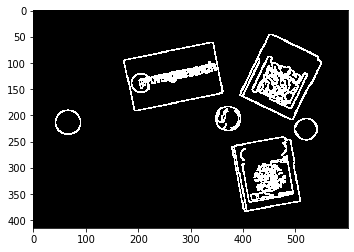

In [8]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
# edged = cv2.erode(edged, None, iterations=1)
plt.imshow(edged, cmap='gray')

In [9]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None
len(cnts)

6

A seguir faremos o resto do processo. Como estamos dentro de um _loop_ condicional faremos os comentários no próprio código. Mas antes de tudo, vamos definir a largura do objeto de referência, a moeda, que conhecemos

In [0]:
widthRef = 2.4257

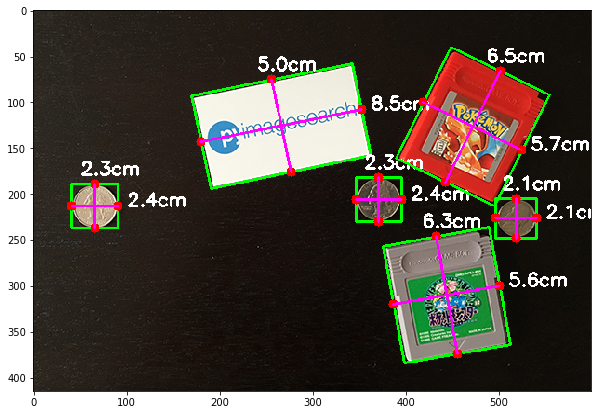

In [11]:
# iteramos cada contorno encontrado
for c in cnts:
  # baseado nos pontos que fazem o contorno do objeto
  # é calculada uma "caixa" (box) que mapeia o objeto na imagem (verde)
  box = cv2.minAreaRect(c)
  box = cv2.boxPoints(box)
  box = np.array(box, dtype="int")
  box = perspective.order_points(box)
  cv2.drawContours(image, [box.astype("int")], -1, (0, 255, 0), 2)

  # a variável box contém os pontos dos cantos da "caixa",
  # que serão usados para calcular o ponto central 
  # de cada lado do objeto 
  (tl, tr, br, bl) = box
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)
  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)

  # nesta etapa, desenhamos o ponto central nos objetos (vermelho)
  cv2.circle(image, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
  cv2.circle(image, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
  cv2.circle(image, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
  cv2.circle(image, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
 
  # desenha uma linha vertical e horizontal passando pelo centro do objeto
  # que será usada para calcular a largura e altura do objeto
  cv2.line(image, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
    (255, 0, 255), 2)
  cv2.line(image, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
    (255, 0, 255), 2)

  # calcula a distância Euclidiana entre os pontos, ou seja, 
  # a largura e altura em termos de distância Euclidiana
  dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
  dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
  # neste código estamos considerando como base o objeto mais a
  # esquerda, ou seja, a moeda. Como os contornos estão ordenados
  # o primeiro é a moeda a esquerda, então na primeira iteração 
  # vamos calcular nossa proporção de medida por pixel (pixelsPerMetric)
  # passando o parâmetro discutido anteriormente
  if pixelsPerMetric is None:
    pixelsPerMetric = dB / widthRef
  
  # calcula o tamanho do objeto
  dimA = dA / pixelsPerMetric
  dimB = dB / pixelsPerMetric
 
  # desenha o tamanho do objeto na imagem
  cv2.putText(image, "{:.1f}cm".format(dimA),
    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (255, 255, 255), 2)
  cv2.putText(image, "{:.1f}cm".format(dimB),
    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (255, 255, 255), 2)
 
plt.figure(figsize = (10,7))	
plt.imshow(image, aspect='auto')

### Exercício #1

Neste exercício, vamos calcular as dimensões dos objetos da imagem acima. Contudo utilizando como o objeto de referência a image com mais predominação da cor branca, ou seja, o cartão branco.

In [0]:
# faça o exercício aqui

## HaarCascade na própria webcam 
Exemplo: FaceDetection/FaceDection.py
Rodar: python FaceDetection.py
